# Prétraitement : Le réseau de neurones à convolution

Dans cette partie nous présentons notre utilisation de l'architecture des réseaux de neurones à convolution pour le prétraitement des données brutes.

## Pourquoi utiliser une telle architecture ?

Depuis leur invention par Y. Lecun (1989), les réseaux de neurones à convolution, ou CNN, ont démontré leur efficacité pour "l'extraction" de caractèristiques pertinentes. Désormais présents dans de très nombreuses applications de l'intelligence artificielle, nous avons voulu les mettre à l'épreuve sur nos données brutes.

Notre intuition est que le coclustering utilise des caractéristiques pertinentes pour classer les données. Les CNN étant spécialisés dans l'extraction de ces caractéristiques, ils devraient donner des résultats particulièrement intéressants.


In [ ]:
#@title Imports

import utils.io as io
import utils.merging as merging
import utils.tools as tools
import utils.scoring as scoring
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
kl = tf.keras.layers

In [ ]:
#@title Création du CNN

class CNN_dense_bis():

    def __init__(self, input_shape, name, model: tf.keras.models.Model = None, **kwargs):
        self.input_shape = input_shape
        self.name = name
        self.model = model

    def build_model(self):

        input_layer = kl.Input(self.input_shape)

        x = kl.Conv1D(filters=16, kernel_size=3, strides=1,
                      padding='valid', activation='relu')(input_layer)
        x = kl.MaxPool1D(pool_size=2, strides=2, padding='same')(x)
        x = kl.Dropout(0.3)(x)

        y = kl.Conv1D(filters=32, kernel_size=3, strides=1,
                      padding='valid', activation='relu')(x)
        y = kl.MaxPool1D(pool_size=2, strides=2, padding='same')(y)
        y = kl.Dropout(0.3)(y)

        z = kl.Flatten()(y)
        z = kl.Dense(128, activation='sigmoid')(z)

        a = kl.Dense(6, activation='softmax')(z)

        model = tf.keras.models.Model(inputs=input_layer, outputs=a, name="preprocess")
        model.summary()
        self.model = model

    def save_model(self):
        tf.keras.models.save_model(
            self.model, './saved_models/' + self.name, save_format='h5')

    def load_model(self):
        self.model = tf.keras.models.load_model(
            './saved_models/' + self.name)
        self.model.summary()

    def build_first_conv(self):

        input_layer = kl.Input((None, 9))
        x = kl.Conv1D(filters=16, kernel_size=3, strides=1,
                      padding='valid', activation='relu')(input_layer)
        x = kl.MaxPool1D(pool_size=2, strides=2, padding='same')(x)
        model = tf.keras.models.Model(inputs=input_layer, outputs=x)
        model.set_weights(self.model.get_weights()[:2])
        return model

    def build_second_conv(self):

        input_layer = kl.Input((None, 9))
        x = kl.Conv1D(filters=16, kernel_size=3, strides=1,
                      padding='valid', activation='relu')(input_layer)
        x = kl.MaxPool1D(pool_size=2, strides=2, padding='same')(x)
        y = kl.Conv1D(filters=32, kernel_size=3, strides=1,
                      padding='valid', activation='relu')(x)
        y = kl.MaxPool1D(pool_size=2, strides=2, padding='same')(y)
        model = tf.keras.models.Model(inputs=input_layer, outputs=y)
        model.set_weights(self.model.get_weights()[:4])
        return model

    def build_dense(self):

        input_layer = kl.Input((128, 9))
        x = kl.Conv1D(filters=16, kernel_size=3, strides=1,
                      padding='valid', activation='relu')(input_layer)
        x = kl.MaxPool1D(pool_size=2, strides=2, padding='same')(x)
        y = kl.Conv1D(filters=32, kernel_size=3, strides=1,
                      padding='valid', activation='relu')(x)
        y = kl.MaxPool1D(pool_size=2, strides=2, padding='same')(y)
        z = kl.Flatten()(y)
        z = kl.Dense(128, activation='sigmoid')(z)

        model = tf.keras.models.Model(inputs=input_layer, outputs=z)
        model.set_weights(self.model.get_weights()[:6])
        return model

In [ ]:
#@title Création du dataset

LABELS = {
    1: 'WALKING',
    2: 'WALKING_UPSTAIRS',
    3: 'WALKING_DOWNSTAIRS',
    4: 'SITTING',
    5: 'STANDING',
    6: 'LAYING'
}

# Loading Dataset #
trainX, trainy, testX, testy = io.load_dataset()
X = np.concatenate((trainX, testX))
# X = testX

train_labels = io.readFile('./original_data/train/y_train.txt')
test_labels = io.readFile('./original_data/test/y_test.txt')
labels = np.concatenate((train_labels, test_labels))
labels = np.reshape(labels, (labels.shape[0], ))

train_subjects = io.readFile(
    './original_data/train/subject_train.txt')
test_subjects = io.readFile(
    './original_data/test/subject_test.txt')
subjects = np.concatenate((train_subjects, test_subjects))

(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)


In [ ]:
#@title Entraînement du CNN

model_name = "model"

Model = CNN_dense_bis(input_shape=trainX.shape[1:], name=model_name)
try:
    Model.load_model()
except:
    Model.build_model()

opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
Model.model.compile(loss='categorical_crossentropy',
                    optimizer=opt, metrics='accuracy')
Model.model.fit(trainX, trainy,
                batch_size=16, epochs=10, verbose=1)
(loss, accuracy) = Model.model.evaluate(testX, testy)
Model.save_model()

Model: "preprocess"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 128, 9)]          0         
_________________________________________________________________
conv1d_30 (Conv1D)           (None, 126, 16)           448       
_________________________________________________________________
max_pooling1d_30 (MaxPooling (None, 63, 16)            0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 63, 16)            0         
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 61, 32)            1568      
_________________________________________________________________
max_pooling1d_31 (MaxPooling (None, 31, 32)            0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 31, 32)            0

(10299, 1008)


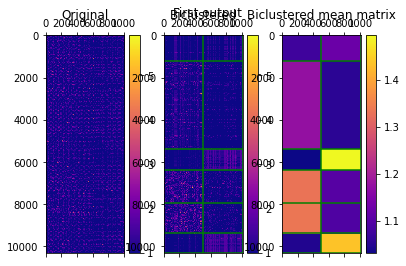

{'SITTING': 0.8871753246753309} 

{'WALKING': 0.17078436075797598, 'WALKING_DOWNSTAIRS': 0.19453106260494252, 'STANDING': 0.4360757975533799} 

{'LAYING': 0.9667338709677351} 

{'WALKING': 0.33162612035851396, 'WALKING_UPSTAIRS': 0.46798975672215337, 'WALKING_DOWNSTAIRS': 0.1997439180537757} 

{'WALKING': 0.3352073085031599, 'WALKING_UPSTAIRS': 0.46451159522135915, 'WALKING_DOWNSTAIRS': 0.19887561489810193} 

{'LAYING': 0.9804560260586322} 

(10299, 992)


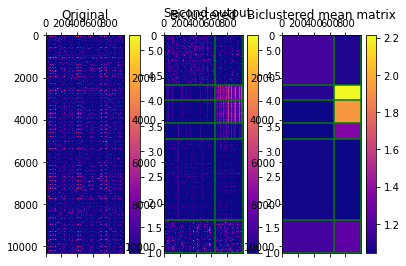

{'WALKING': 0.36651003844511637, 'WALKING_UPSTAIRS': 0.6134130713370359} 

{'LAYING': 1.0000000000000142} 

{'LAYING': 0.9687778768956455} 

{'SITTING': 0.9568733153638743} 

{'WALKING': 0.19425019425019174, 'SITTING': 0.2646982646982605, 'STANDING': 0.49261849261850243} 

{'WALKING_DOWNSTAIRS': 0.845152895250476} 

(10299, 128)


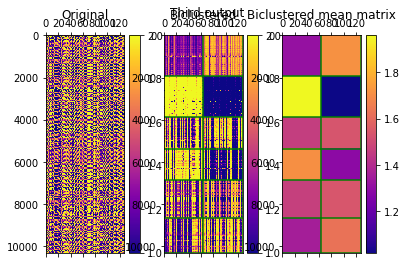

{'STANDING': 0.8501814411612032} 

{'LAYING': 0.9937629937629706} 

{'WALKING_UPSTAIRS': 0.9840848806366298} 

{'WALKING_DOWNSTAIRS': 0.9339118825100226} 

{'SITTING': 0.8537549407114435} 

{'WALKING': 0.9796285200718713} 



In [ ]:
#@title Application au coclustering

model_first_conv = Model.build_first_conv()
model_second_conv = Model.build_second_conv()
model_dense = Model.build_dense()

# Visualisation des coclustering #

first_output = model_first_conv(X).numpy()
first_output = first_output.reshape(
    first_output.shape[0], first_output.shape[1] * first_output.shape[2]) + 1
second_output = model_second_conv(X).numpy()
second_output = second_output.reshape(
    second_output.shape[0], second_output.shape[1] * second_output.shape[2]) + 1
third_output = model_dense(X).numpy() + 1

rows, cols = 6, 2
# Coclustering de la première sortie et détermination des activités
first_cluster, first_array = tools.biclustering_impact_viewer_bis(
    first_output, rows, cols, "First output")
scores1 = scoring.evaluate_clustering(labels, first_cluster)
scores1 = scoring.better_score(scores1, LABELS)
for score in scores1:
    print(score,"\n")

# Coclustering de la seconde sortie et détermination des activités
second_cluster, second_array = tools.biclustering_impact_viewer_bis(
    second_output, rows, cols, "Second output")
scores2 = scoring.evaluate_clustering(labels, second_cluster)
scores2 = scoring.better_score(scores2, LABELS)
for score in scores2:
    print(score,"\n")

# Coclustering de la troisième sortie et détermination des activités
third_cluster, third_array = tools.biclustering_impact_viewer_bis(
    third_output, rows, cols, "Third output")
scores3 = scoring.evaluate_clustering(labels, third_cluster)
scores3 = scoring.better_score(scores3, LABELS)
for score in scores3:
    print(score,"\n")


0.0010697216326024496 (2, 2) [0.0010697216326024496, 0.0019239232125414078, 0.001525926143721567, 0.002000845304232127, 0.003335582570225773, 0.0036093283477308833, 0.006417856602507366, 0.007121530283434527, 0.008620072502498995, 0.003151057260577738, 0.002018542415548763, 0.002072645773577417, 0.0025376482958922295, 0.00367643302673616, 0.003903250563190498, 0.006740135668172549, 0.008258422541638721, 0.008781545571266291, 0.0046537336347029475, 0.0029556440014542945, 0.0024497767702966306, 0.0026753548527097674, 0.00376561878751125, 0.0047760500409090014, 0.006861286054494524, 0.008404282622209132, 0.008833379214400288, 0.0044689425375921, 0.0027599557873106595, 0.0028373339491291906, 0.002806657368811771, 0.003623470173790952, 0.004934518465902515, 0.006995615860737144, 0.008570847461286652, 0.009069747520419558, 0.005052394867948163, 0.003790121988868027, 0.003228078121029348, 0.0029077553653277907, 0.003987066525611492, 0.0046463902333430986, 0.007228276339986062, 0.0078218525779

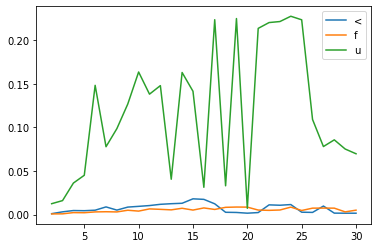

In [ ]:
#@title Recherche du meilleur coclustering

scoring.get_best_score(
    first_output, subjects, 30, scoring.DB_score, 'min')
scoring.get_best_score(
    second_output, subjects, 30, scoring.DB_score, 'min')
scoring.get_best_score(
    third_output, subjects, 30, scoring.DB_score, 'min')
plt.show()

On trouve donc que les meilleurs coclusters sont :
(2,2) pour la première sortie
(2,2) pour la seconde sortie
(2,4) pour la troisième sortie